# Spotlight Search

Use change in pocket area to find the best pass rushers.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt

from ast import literal_eval

## Pseudocode

1. Filter `play_metrics` to only the `before_end` time window
1. Augment `play_metrics` with the percentage change of the area between the window start and end
1. Filter `play_metrics` to only plays with a high pocket area loss according to percentage change
1. Augment `pocket_areas` with a column that contains the vertices from the pocket metadata, if any
1. Filter `pocket_areas` to only frames with vertices in the pocket metadata
1. Left join the filtered `play_metrics` to `pocket_areas` to get the vertices for the start and end frames
1. Filter the join result to only windows that have vertices for both their start and end frames
1. Augment the join result with `shapely` polygons from the vertices
1. Augment the join result the polygon difference between the start and end polygons
1. This result provides `spotlight_windows`, the spotlight area for each selected play window
1. Filter `tracking_display` to blockers and rushers
1. Left join `spotlight_windows` to `tracking_display` to get the filtered players for that frame
1. This result provides `spotlight_players`, the players that could be in the spotlight area
1. Augment the join result with an indicator column for whether or not each player is in the spotlight area
1. Filter the join result to players who are in the spotlight area
1. Aggregate the players in the spotlight area to calculate how many blockers are in the spotlight area
1. Aggregate the players in the spotlight area to calculate how many rushers are in the spotlight area
1. Left join `spotlight_windows` to the aggregated columns from `spotlight_players`
1. Left join `spotlight_windows` to `plays` to pull in additional dimensions about the play
1. Query the augmented `spotlight_windows` to find spotlight moments of interest

See `src/pipeline/tasks/spotlight.py` for the implementation. Start reading the outline in `get_spotlight_data()`.

## Data Processing

In [4]:
df_plays = pd.read_csv(f"{DIR}/data/raw/plays.csv")
df_tracking = pd.read_csv(f"{DIR}/data/processed/tracking_display.csv")
df_play_metrics = pd.read_csv(f"{DIR}/data/processed/play_metrics.csv")
df_areas = pd.read_csv(f"{DIR}/data/processed/pocket_areas.csv")
df_areas["pocket"] = df_areas["pocket"].apply(literal_eval)

In [5]:
from src.pipeline.tasks.spotlight import get_spotlight_data


df_spotlight_search = get_spotlight_data(df_tracking, df_play_metrics, df_areas, df_plays)

## Exploration

In [6]:
cols = [
    "gameId",
    "playId",
    "time_start",
    "time_end",
    "area_start",
    "area_end",
    "percentage_change",
    "count_blockers",
    "all_blockers",
    "count_rushers",
    "all_rushers",
    "passResult",
    "playResult",
]
query_search = (
    "percentage_change >= 0.99 "
    "and count_blockers >= 1 "
    "and count_rushers >= 1 "
    "and passResult in ('S', 'I') "
)
sorts = [
    ("percentage_change", "ASC")
]
df_results = df_spotlight_search.query(query_search)
df_results = df_results.sort_values(
    by=[s[0] for s in sorts],
    ascending=[s[1].lower().startswith("asc") for s in sorts],
)
df_results[cols].head()

,gameId,playId,time_start,time_end,area_start,area_end,percentage_change,count_blockers,all_blockers,count_rushers,all_rushers,passResult,playResult
700,2021091212,421,2.4,4.4,14.63265,0.13445,0.990812,1.0,[71],1.0,[93],S,-8
1674,2021092000,970,3.2,5.2,22.55310,0.18550,0.991775,3.0,"[74, 71, 70]",1.0,[97],S,-8
234,2021091202,3420,2.1,4.1,19.74545,0.15525,0.992137,1.0,[25],1.0,[49],S,-10
1298,2021091906,3858,2.5,4.5,23.23935,0.16945,0.992708,1.0,[62],1.0,[55],S,-11
1702,2021092000,3294,2.5,4.5,12.40950,0.07730,0.993771,1.0,[28],1.0,[8],S,-10


## Visualizations

In [7]:
from src.visualization.interactive_pocket_area import get_spotlight_plotter


plot_spotlight = get_spotlight_plotter(df_tracking, df_spotlight_search)

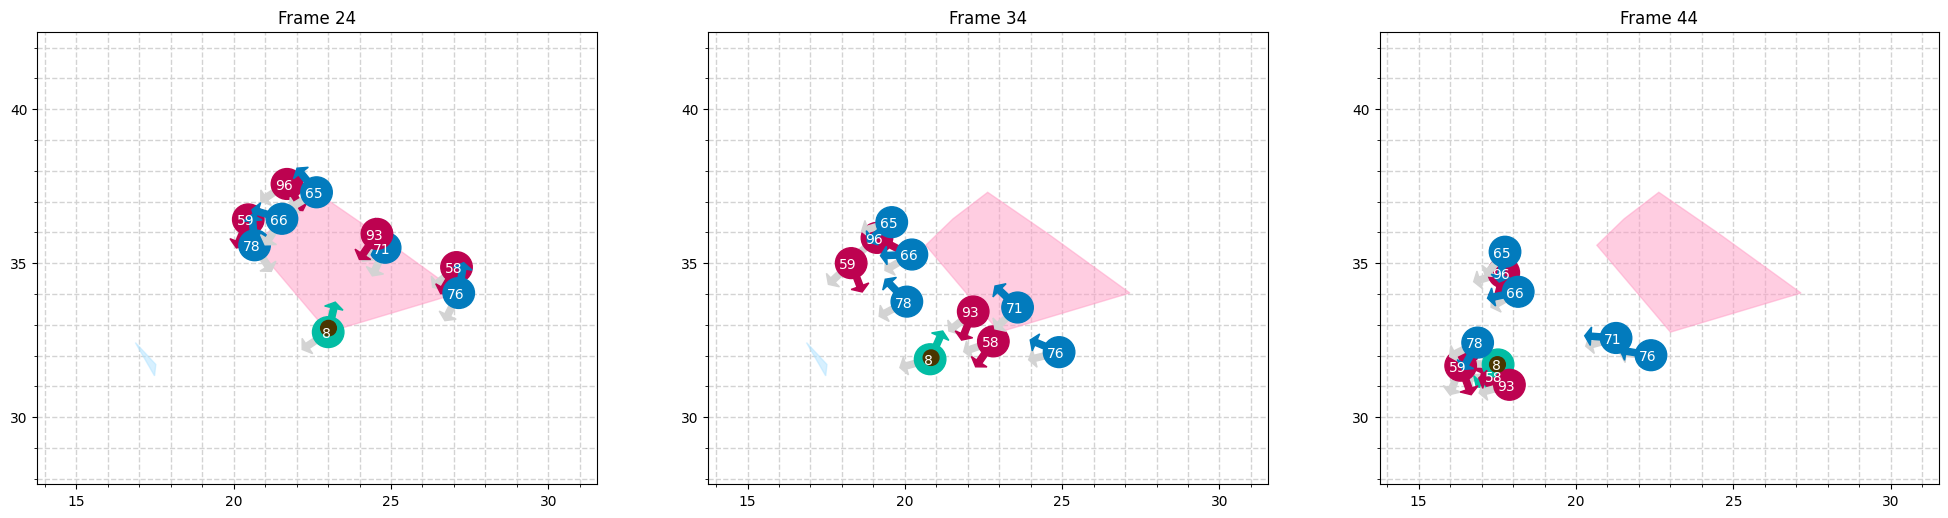

In [8]:
plot_spotlight(game_id=2021091212, play_id=421)

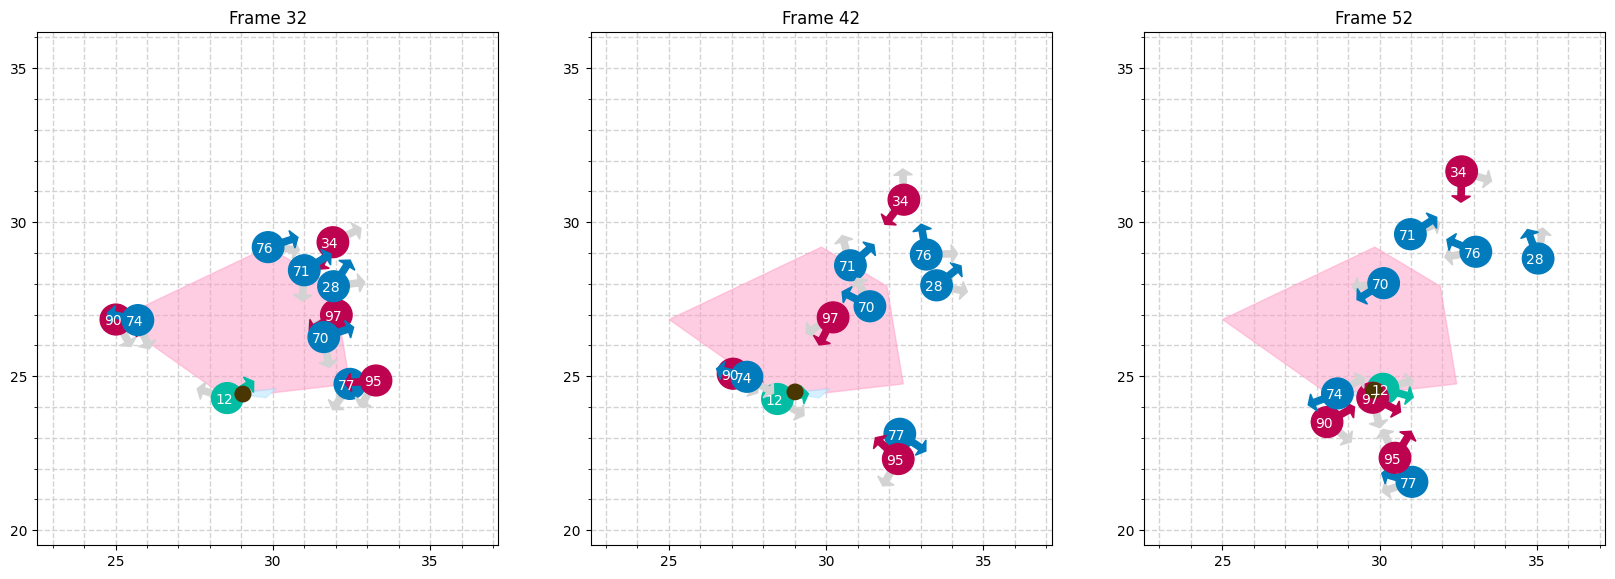

In [9]:
plot_spotlight(game_id=2021092000, play_id=970)

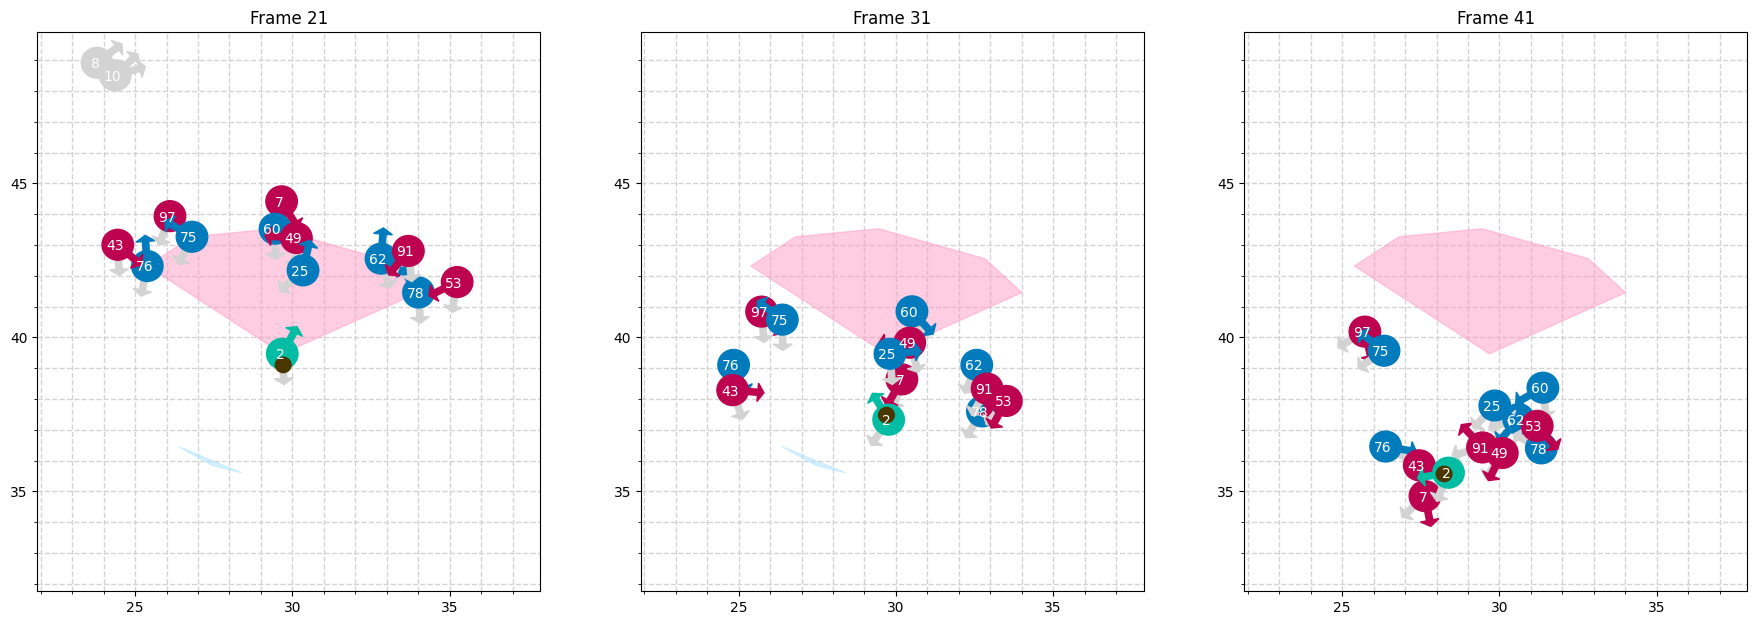

In [10]:
plot_spotlight(game_id=2021091202, play_id=3420)

In [11]:
from src.visualization.interactive_play_selector import create_interactive_play_selector


create_interactive_play_selector(
    df_plays,
    df_tracking,
    df_areas,
    continuous_update=True
)

interactive(children=(Dropdown(description='Week', options=(1, 2), value=1), Dropdown(description='Game ID', o…

In [12]:
from matplotlib.ticker import MultipleLocator


def plot_area_percentage_change_distribution(ser, cumulative: bool = False):
    # Note, all values outside the bin range will go into the
    # last bin on each side, possibly skewing the numbers.
    # To address this, we add one more bin to each side of the
    # desired range, so that those bins will contain outliers.
    bin_size = 0.1
    if cumulative:
        bin_size = 0.01
    bin_min = -2.0
    bin_max = 1.0
    bins = np.arange(bin_min - bin_size, bin_max + bin_size, bin_size)
    
    hist, bin_edges = np.histogram(ser, bins)
    hist_percentage = 100 * hist / hist.sum()
    bars = hist_percentage
    if cumulative:
        bars = hist_percentage.cumsum()

    fig, ax = plt.subplots(1, 1)
    pal = sns.hls_palette(1)

    ax.bar(
        x=bin_edges[1:],
        height=bars,
        # Use edge align with negative bin width so that
        # horizontal axis tick matches the bin edge.
        width=(-1 * bin_size),
        align="edge",
        color=pal[0]
    )

    ax.set_xlabel("Pocket Area % Change in Ending Window")
    ax.set_ylabel("Percentage of Passing Plays")
    if cumulative:
        ax.set_ylabel("Cumulative Percentage of Passing Plays")

    ax.set_ylim(0, bars.max() * 1.05)
    
    ax.xaxis.set_major_locator(MultipleLocator(2 * bin_size))
    ax.xaxis.set_minor_locator(MultipleLocator(bin_size))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    if cumulative:
        ax.xaxis.set_major_locator(MultipleLocator(20 * bin_size))
        ax.xaxis.set_minor_locator(MultipleLocator(10 * bin_size))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))

    ax.axvline(0, linestyle="--", color="black")
    ax.grid(which="both", linestyle="--", color="lightgray")

    fig.set_size_inches(12, 6)
    plt.show()

In [13]:
ser = df_spotlight_plays.query(f"method == '{default_area}'")["percentage_change"]
plot_area_percentage_change_distribution(ser)

NameError: name 'df_spotlight_plays' is not defined

In [ ]:
plot_area_percentage_change_distribution(ser, cumulative=True)